In [1]:
import sys
sys.path.append('../')

import tquant as tq

from datetime import date, timedelta
import tensorflow as tf
# import pandas as pd
from datastore import *

# Settings

In [2]:
tq.Settings.evaluation_date = date(2024, 4, 30)

calendar = tq.TARGET()
daycounter = tq.DayCounter(tq.DayCounterConvention.Actual360)
evaluation_date = tq.Settings.evaluation_date

# Market

In [3]:
rates = ir_eur_curve_estr['quote'].values
times = ir_eur_curve_estr['daycount'].values/365

rates_6m = ir_eur_curve_6m['quote'].values
times_6m = ir_eur_curve_6m['daycount'].values/365

estr_curve = tq.RateCurve(times, rates)
eur6m_curve = tq.RateCurve(times_6m, rates_6m)

# Swap

In [4]:
# --------------
# fixed leg
start_date = date(2015,12,31)
fixed_schedule = [start_date]
fixed_schedule.extend([start_date + timedelta(365 *.5 *i) for i in range(1,51)])
fixed_rate = [0.04156]*(len(fixed_schedule)-1)
fixed_notional = [143857602,142099704,140995554,139343227,138170625,136487409,135100610,133235348,131633135,130088055,
                128443001,126527961,124478813,122046073,119540895,117334856,115325682,113682288,112374057,110400222,108996590,
                107427609,106277787,104934949,103826978,102318265,101011839,99241108,97427949,95062460,92643968,89488286,86306759,
                82654668,79233393,75249260,71491885,67239725,63147273,58562602,54101515,49235670,44484930,39276217,34122360,28587822,
                23186787,17327243,11581997,5627771]
fixed_notional = [-1*n for n in fixed_notional]
fixed_daycounter = tq.DayCounter(tq.DayCounterConvention.Actual360)
# --------------
# floating leg
floating_schedule = [start_date]
floating_schedule.extend([start_date + timedelta(365 *.5 *i) for i in range(1,51)])

floating_notional = [0,0,0,0,0,0,0,0,0,0,
    128443001,126527961,124478813,122046073,119540895,117334856,115325682,113682288,112374057,110400222,108996590,
    107427609,106277787,104934949,103826978,102318265,101011839,99241108,97427949,95062460,92643968,89488286,86306759,
    82654668,79233393,75249260,71491885,67239725,63147273,58562602,54101515,49235670,44484930,39276217,34122360,28587822,
    23186787,17327243,11581997,5627771]

index_6m = tq.IborIndex('EUR6M',
             calendar,
             6,
             tq.TimeUnit.Months)
spread = [0.] *(len(floating_schedule)-1)
gearing = [1.] *(len(floating_schedule)-1)
floating_daycounter = tq.DayCounter(tq.DayCounterConvention.Actual360)
# --------------
# fixing
index_6m.add_fixing(date(2023, 12,29), 0.03)

# --------------
# swap object

swap = tq.InterestRateSwap(floating_schedule, fixed_schedule,
                    floating_notional, fixed_notional, gearing, spread,
                    index_6m, fixed_rate, fixed_daycounter, floating_daycounter)


In [5]:
swap_engine = tq.SwapAnalyticEngine(swap)

In [6]:
npv_swap = swap_engine.price(estr_curve, eur6m_curve, evaluation_date)

In [7]:
floating_leg_pricer = tq.FloatingLegDiscounting(swap.floating_leg)
fixed_leg_pricer = tq.FixedLegDiscounting(swap.fixed_leg)

npv_float = floating_leg_pricer.price(estr_curve, eur6m_curve, evaluation_date, tq.FloatingCouponDiscounting)
npv_fixed = fixed_leg_pricer.price(estr_curve, evaluation_date, tq.FixedCouponDiscounting)

print(f"NPV FixedLeg: {npv_fixed :,.0f}")
print(f"NPV FloatingLeg: {npv_float :,.0f}")
########
print(f"NPV Swap: {npv_swap :,.0f}")

NPV FixedLeg: -45,294,184
NPV FloatingLeg: 31,530,407
NPV Swap: -13,763,777


In [8]:
npv_swap, tape = swap_engine.price_aad(estr_curve, eur6m_curve, evaluation_date)
sensitivities = tape.gradient(npv_swap, [estr_curve.rates, eur6m_curve.rates])

In [9]:
# Function to extract values from TensorFlow tensors
def extract_value(x):
    if isinstance(x, tf.Tensor):
        return x.numpy()  # Extract value from TensorFlow tensor
    else:
        return x

In [10]:
sensy_estr = pd.DataFrame([estr_curve.pillars.tolist(), sensitivities[0]]).T
sensy_estr.columns = ['time', 'sensy_estr']
sensy_estr.fillna(0, inplace = True)
sensy_estr.set_index('time', inplace = True)
sensy_estr['sensy_estr'] = sensy_estr['sensy_estr'].apply(extract_value)

In [11]:
sensy_eur6m = pd.DataFrame([eur6m_curve.pillars.tolist(), sensitivities[1]]).T
sensy_eur6m.columns = ['time', 'sensy_eur6m']
sensy_eur6m.fillna(0, inplace = True)
sensy_eur6m.set_index('time', inplace = True)
sensy_eur6m['sensy_eur6m'] = sensy_eur6m['sensy_eur6m'].apply(extract_value)

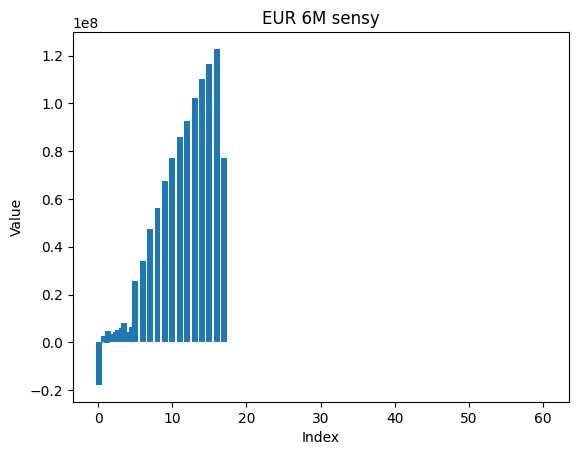

In [12]:
import matplotlib.pyplot as plt
# Plot line chart of column 'A'
plt.bar(sensy_eur6m.index, sensy_eur6m['sensy_eur6m'])
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('EUR 6M sensy')
plt.show()

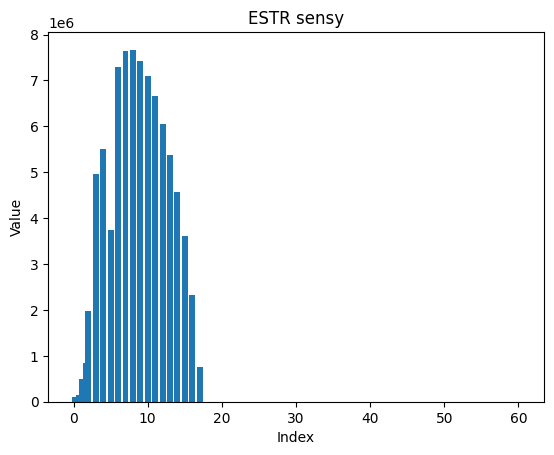

In [13]:
# Plot line chart of column 'A'
plt.bar(sensy_estr.index, sensy_estr['sensy_estr'])
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('ESTR sensy')
plt.show()

# Tensor Pricing 

## simulate random 1M curves

In [14]:
# instance of the hull-white model for 1M curve simulation
mean_rev = 0.02
sigma = 0.045
hw = tq.HullWhiteProcess(mean_rev, sigma, market_curve=estr_curve)
hw_kernel = tq.GaussianRateKernel1D(hw)

# simulate short rate and discount curve 
paths = int(1e6) 
r_tensor, zb_tensor, grid = hw_kernel.rate_tensor(paths,
                                                  last_grid_time=1,
                                                  time_steps=2) # evaluation_date + 1y
# Reshape the tensor and create a discount curve object
reshaped_tensor = tf.reshape(zb_tensor, shape=(zb_tensor.shape[1], paths, 1))
rate_curve_tensor = tq.DiscountCurveSimple(times, reshaped_tensor)

## swap price for 1M simulated curves

In [15]:
npv_swap = swap_engine.price(rate_curve_tensor, rate_curve_tensor, evaluation_date)

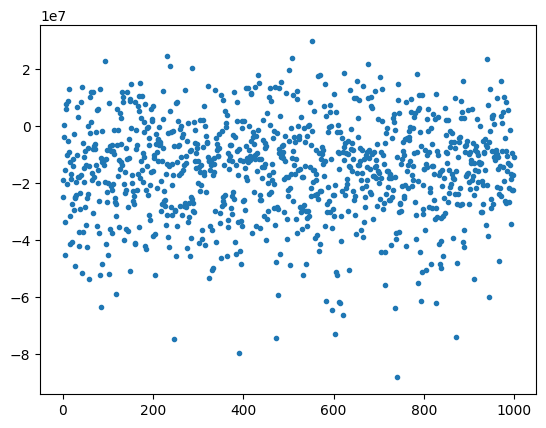

In [16]:
plt.plot(npv_swap[:1000], '.');